In [1]:
import spacy
import pandas as pd
import numpy as np
from collections import Counter
from glob import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

# The following are optional dependencies. 
# Feel free to comment these out. 
# Sent2tree uses the sent2tree.py module in this repository. 
#from sent2tree import sentenceTree
#import ete3 
import seaborn

In [2]:
import sys
print (sys.path)

print ('inserting...')

sys.path.insert(0, 's:\\git\\tacticsiege\\TacticToolkit')


import ttk



['', 'S:\\Anaconda3\\python36.zip', 'S:\\Anaconda3\\DLLs', 'S:\\Anaconda3\\lib', 'S:\\Anaconda3', 'S:\\Anaconda3\\lib\\site-packages', 'S:\\Anaconda3\\lib\\site-packages\\Mako-1.0.7-py3.6.egg', 'S:\\Anaconda3\\lib\\site-packages\\contextlib2-0.5.5-py3.6.egg', 'S:\\Anaconda3\\lib\\site-packages\\cycler-0.10.0-py3.6.egg', 'S:\\Anaconda3\\lib\\site-packages\\win32', 'S:\\Anaconda3\\lib\\site-packages\\win32\\lib', 'S:\\Anaconda3\\lib\\site-packages\\Pythonwin', 'S:\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\TacticSiege\\.ipython']
inserting...


In [3]:
nlp = spacy.load('en')

In [4]:
sents_raw = [
    'Puerto Rico Spared the Worst; Florida Braces for Direct Hit',
    'Hurricane Irma Tears Through Caribbean',
    'Equifax Says Attack May Have Affected Millions of Users',
    'The Fake Americans That Russia Created to Sway the Election',
    "Trump Jr. Says He Sought Information on Clinton’s ‘Fitness’",
]

In [5]:
# create sentences out of headlines with a '. '
headlines = nlp('. '.join(sents_raw))

In [6]:
headlines[:18]

Puerto Rico Spared the Worst; Florida Braces for Direct Hit. Hurricane Irma Tears Through Caribbean.

In [7]:
# sents is a generator
for s in headlines.sents:
    print (s)

Puerto Rico Spared the Worst; Florida Braces for Direct Hit.
Hurricane Irma Tears Through Caribbean.
Equifax Says Attack May Have Affected Millions of Users.
The Fake Americans That Russia Created to Sway the Election.
Trump Jr. Says He Sought Information on Clinton’s ‘
Fitness’


In [8]:
len(list(headlines.sents))

6

In [9]:
set([w.label_ for w in headlines.ents])

{'CARDINAL', 'EVENT', 'GPE', 'ORG', 'PERSON'}

In [10]:
[ent for ent in headlines.ents if ent.label_=='CARDINAL']

[Millions]

In [11]:
# Make a quick-and-dirty lookup table of POS IDs, 
# since the default representation of a POS is numeric. 
tagDict = {w.pos: w.pos_ for w in headlines} 
tagDict

{83: 'ADP',
 88: 'DET',
 90: 'NOUN',
 92: 'PART',
 93: 'PRON',
 94: 'PROPN',
 95: 'PUNCT',
 98: 'VERB'}

In [12]:
[w for w in headlines if w.pos_ == 'PROPN']

[Puerto,
 Rico,
 Worst,
 Florida,
 Direct,
 Hit,
 Hurricane,
 Irma,
 Tears,
 Through,
 Caribbean,
 Equifax,
 Attack,
 Fake,
 Americans,
 Russia,
 Created,
 Trump,
 Jr.,
 Clinton,
 ’s,
 Fitness’]

In [13]:
sents_list = list(headlines.sents)
s = sents_list[2]
s

Equifax Says Attack May Have Affected Millions of Users.

In [14]:
for w in s:
    print (w, w.tag_, w.pos_)

Equifax NNP PROPN
Says VBZ VERB
Attack NNP PROPN
May MD VERB
Have VB VERB
Affected VBN VERB
Millions NNS NOUN
of IN ADP
Users NNS NOUN
. . PUNCT


In [15]:
# look at sentence properties
[prop for prop in dir(s) if not prop.startswith('_')]

['doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'has_vector',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'lower_',
 'merge',
 'noun_chunks',
 'orth_',
 'rights',
 'root',
 'sent',
 'sentiment',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'text',
 'text_with_ws',
 'upper_',
 'vector',
 'vector_norm']

In [16]:
for nc in s.noun_chunks:
    print (nc)

Equifax
Attack
Millions
Users


In [24]:
import ete3
from ete3 import Tree
from ete3.treeview import TreeStyle, TextFace, add_face_to_node

class sentenceTree(): 
    def __init__(self, sent): 
        """ Takes a SpaCy sentence as input. """ 
        self.sent = sent
        self.root = sent.root
        print(self.sent)
        self.sentDict = self.sentToDict(self.root)
        self.newick = self.newickify(self.sentDict) + ';'

    def isPunct(self, thing): 
        if type(thing) == str: 
            if thing.strip() in "!@#$%^&*()_+-=,./<>?;':[]\{}|`~": 
                return True
        return False

    def sentToDict(self, node): 
        children = [child for child in node.children 
                   if self.isPunct(child.string.strip()) == False # ignore punctuation
                   and child.tag_ != 'SP'] #ignore spaces and newlines
        root = node.string.strip()
        if len(children) == 0: 
            return node.string.strip()
        return {node.string.strip(): [self.sentToDict(child) 
                                      for child in children]}

    def newickify(self, node): 
        if type(node) == str:
            return node.strip()
        root = list(node)[0]
        return '(' + ','.join([self.newickify(child) 
            for child in node[root] ]) + ')' + root
    
    def render(self, textMode=False): 
        """ 
        textMode=False will show a graphical tree. 
        textmode=True will show an ASCII tree. 
        """
        t = Tree(self.newick, format=1)
        if textMode: 
            print(t.get_ascii(show_internal=True))
        else: 
            ts = TreeStyle()
            ts.show_leaf_name = False
            #TODO: make this not be a function
            def my_layout(node):
                F = TextFace(node.name, tight_text=False)
                add_face_to_node(F, node, column=0, position="branch-right")
            ts.layout_fn = my_layout
            t.render('%%inline', tree_style=ts)
            return t, ts



In [25]:
s.root

Says

In [26]:
list(s.root.children)

[Equifax, Affected, .]

In [27]:
## ok so I may want an nlp object from each headline...
# Look into tree plotting library, ete3 maybe not works on windows?  (DONE)
# Evaluate github project hosting....
# skim other projects for structure ideas (DONE-continuous)

In [21]:
class BaseClass(object):
    def foo(self):
        print ('do stuff...')
        self.bar()
        print ('do more stuff...')

    def bar(self):
        print ('base bar')

class DerivedClass(BaseClass):
    def bar(self):
        print ('derived bar')


myObj = DerivedClass()
myObj.foo()

do stuff...
derived bar
do more stuff...


In [28]:
s

Equifax Says Attack May Have Affected Millions of Users.

Equifax Says Attack May Have Affected Millions of Users.


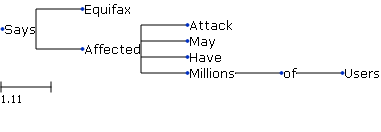

In [33]:
rcParams['figure.figsize'] = (10, 6)
st = sentenceTree(s)
t, ts = st.render()
from t.render('%%inline', tree_style=ts)

Hurricane Irma Tears Through Caribbean.


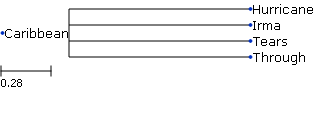

In [42]:
from IPython.display import display

s = sents_list[1]
rcParams['figure.figsize'] = (10, 6)
st = sentenceTree(s)
t, ts = st.render()
x = t.render('%%inline', tree_style=ts)

display(x)

Puerto Rico Spared the Worst; Florida Braces for Direct Hit.


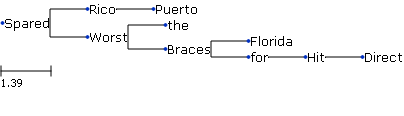

Hurricane Irma Tears Through Caribbean.


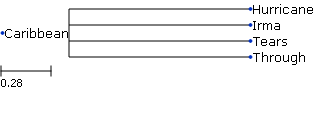

Equifax Says Attack May Have Affected Millions of Users.


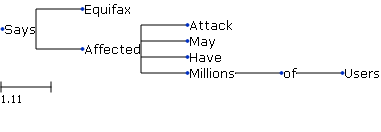

The Fake Americans That Russia Created to Sway the Election.


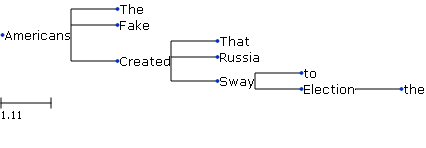

Trump Jr. Says He Sought Information on Clinton’s ‘


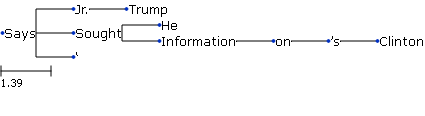

Fitness’


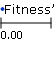

In [43]:
for i in range(len(sents_list)):
    s = sents_list[i]
    rcParams['figure.figsize'] = (10, 6)
    st = sentenceTree(s)
    t, ts = st.render()
    x = t.render('%%inline', tree_style=ts)
    display(x)